# Crash Predictive ML Model

We will create a Logistic Regression or Tree based model to predict the daily number of crashes at a known intersection using the following:
- weather (temp, snow, rain, precip)
- day of week (Mon, Tues...)
- intersection characteristics
    - speed limit
    - volume of traffic
    - region
    - lanes/ways/turns/split/exit etc.
- violations (may want a violations independent model)
- red light cam present

In [1]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from modules.myfuncs import *


import warnings
warnings.filterwarnings('ignore')


# Decision Tree
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support


import pandas as pd
import numpy as np
import itertools

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE, ADASYN

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
conn = create_connection('database/rlc.db')  # function from myfuncs file
c = conn.cursor()

sqlite3 version: 2.6.0
connected to database/rlc.db



We will try to get data that is daily for all of the above info.  

In [7]:
print(sql_fetch_tables(c, conn))



def table_info(c, conn):
    '''
    prints out all of the columns of every table in db
    c : cursor object
    conn : database connection object
    '''
    tables = c.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
    for table_name in tables:
        table_name = table_name[0]
        table = pd.read_sql_query("SELECT * from {} LIMIT 0".format(table_name), conn)
        print(table_name)
        for col in table.columns:
            print('\t' + col)
        print()

table_info(c, conn)


[('cam_locations',), ('cam_startend',), ('daily_violations',), ('all_crashes',), ('hourly_congestion',), ('hourly_weather',), ('region_data',), ('intersection_cams',), ('all_hours',), ('int_startend',), ('intersection_chars',), ('signal_crashes',), ('rlc_all_hours',), ('daily_covid',), ('holidays',)]
cam_locations
	camera_id
	intersection
	address
	violation_date
	violations
	latitude
	longitude
	month
	day
	weekday
	year

cam_startend
	camera_id
	start
	end

daily_violations
	intersection
	camera_id
	address
	violation_date
	violations
	latitude
	longitude
	month
	day
	weekday
	year

all_crashes
	crash_record_id
	rd_no
	crash_date
	posted_speed_limit
	traffic_control_device
	device_condition
	weather_condition
	lighting_condition
	first_crash_type
	trafficway_type
	alignment
	roadway_surface_cond
	road_defect
	report_type
	crash_type
	damage
	prim_contributory_cause
	sec_contributory_cause
	street_no
	street_direction
	street_name
	beat_of_occurrence
	num_units
	most_severe_injury
	in

## Query our data
I would like to get hourly intersection data with the following columns:


signal_crashes
	-crash_date
	-posted_speed_limit
	-device_condition
	-weather_condition
	-lighting_condition
	-first_crash_type
	-trafficway_type
	-alignment
	-roadway_surface_cond
	-road_defect
	-report_type
	-crash_type
	-damage
	-prim_contributory_cause
	-sec_contributory_cause
	-street_no
	-street_direction
	-street_name
	-most_severe_injury
	-injuries_total
	-injuries_fatal
	-injuries_incapacitating
	-injuries_non_incapacitating
	-injuries_reported_not_evident
	-injuries_no_indication
	-injuries_unknown
	-latitude
	-longitude
	-lane_cnt
	-work_zone_i
	-work_zone_type
	-workers_present_i
	-intersection
	-year
	-month
	-day
	-hour
	-region_id
	-time
	-weekday

hourly_weather
	-temp
	-rain_1h
	-rain_3h
	-snow_1h
	-snow_3h
	-time
	-year
	-month
	-day
	-hour
	-weekday

hourly_congestion
	-year
	-month
	-day
	-hour
	-region_id
	-bus_count
	-num_reads
	-speed
	-weekday
    
Tables will be queried to JOIN on year, month, day, hour

WHAT I REALLY NEED HERE
A single dataset with the following:
- daily intersection chars (all the stuff I entered)
- daily intersection crashes (injuries, deaths, number etc)
- daily wx (temp, precip mainly)
- daily congestion (might not need this)
- daily violations (already in the format)

In [8]:
# Approximately how many entries should I expect to be looking at after filtering my data
# 3 years, 4 months x 153 intersections
print((365.25*3 + 30*4) *153)


186009.75


## Query my db to get a DataFrame with crashes and intersection
We will be using the number of crashes and injuries to do some t-tests

In [13]:
# USE THIS ONE!!!!

big_df = pd.read_sql_query('''
WITH ah AS(SELECT d.year,
                d.month,
                d.day,
                d.intersection,
                d.datetime,
                rg.region_id,
                d.rlc_state

            FROM rlc_all_hours as d
            LEFT JOIN intersection_cams as rg
                ON d.intersection = rg.intersection
            GROUP BY d.year, d.month, d.day, d.intersection
        ), 

    se AS(SELECT *
         FROM int_startend as se
        ),

    cr AS(SELECT *
         FROM signal_crashes
        ),

    ic AS(SELECT *
        FROM intersection_chars
        ),

    wx AS(SELECT MAX(temp) AS temp,
                (SUM(snow_1h) + SUM(rain_1h)) AS precip,
                SUM(snow_1h) AS snow_1h,
                SUM(rain_1h) AS rain_1h,
                year,
                month,
                day
        FROM hourly_weather
        GROUP BY year, month, day
        ),
    cov AS(SELECT strftime('%m',lab_report_date) AS month,
                strftime('%Y',lab_report_date) AS year,
                strftime('%d',lab_report_date) AS day,
                lab_report_date,
                cases_total
            FROM daily_covid
            ),
            
     cg AS(SELECT (100-AVG(quantile_speed))/100 as mean_congestion,
             (100-MAX(quantile_speed))/100 as max_congestion,
             year,
             month,
             day,
             region_id

     FROM hourly_congestion
     GROUP BY year, month, day, region_id
     )
            
    

    SELECT  strftime('%W',ah.datetime) AS week,
            ah.datetime,
            ah.year,
            ah.month,
            ah.day,
            ah.region_id,
            ah.intersection,

            COUNT(DISTINCT cr.crash_record_id) as n_crash,

            cr.prim_contributory_cause,
            cr.sec_contributory_cause,
            SUM(cr.injuries_total) AS injuries,
            SUM(cr.injuries_fatal) AS injuries_fatal,
            SUM(cr.injuries_incapacitating) AS injuries_incapacitating,


            wx.temp,
            wx.precip,
            wx.snow_1h,
            wx.rain_1h,
            

            cov.cases_total
            

    FROM ah
    LEFT JOIN wx
        ON wx.year = ah.year
        AND wx.month = ah.month
        AND wx.day = ah.day  
    LEFT JOIN cr
        ON cr.intersection = ah.intersection
        AND cr.year = ah.year
        AND cr.month = ah.month
        AND cr.day = ah.day
    
    LEFT JOIN cov
        ON cov.year = ah.year
        AND cov.month = ah.month
        AND cov.day = ah.day

    WHERE ah.datetime >= \'2017-09-01\'
        AND ah.datetime <= \'2021-01-31\'
    GROUP BY ah.year, ah.month, ah.day, ah.intersection
    ORDER BY ah.year, ah.month, ah.day, ah.intersection;
                                    ''', conn)

# Change date to speed up, but put it back to sept 1, 2017 when done

In [14]:
big_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194688 entries, 0 to 194687
Data columns (total 18 columns):
week                       194688 non-null object
datetime                   194688 non-null object
year                       194688 non-null int64
month                      194688 non-null int64
day                        194688 non-null int64
region_id                  194688 non-null object
intersection               194688 non-null object
n_crash                    194688 non-null int64
prim_contributory_cause    6265 non-null object
sec_contributory_cause     6265 non-null object
injuries                   6264 non-null float64
injuries_fatal             6264 non-null float64
injuries_incapacitating    6264 non-null float64
temp                       194688 non-null float64
precip                     194688 non-null float64
snow_1h                    194688 non-null float64
rain_1h                    194688 non-null float64
cases_total                52416 non-null obje

In [15]:
cg = pd.read_sql_query('''
SELECT 100-AVG(quantile_speed) as congestion,
        region_id,
        year,
        month,
        day,
        weekday
        
FROM hourly_congestion
GROUP BY year, month, day, region_id
''', conn)

In [17]:
cg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52432 entries, 0 to 52431
Data columns (total 6 columns):
congestion    52432 non-null float64
region_id     52432 non-null object
year          52432 non-null int64
month         52432 non-null int64
day           52432 non-null int64
weekday       52432 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 2.4+ MB


In [18]:
vio = pd.read_sql_query('''
SELECT  violations,
        year,
        month,
        day,
        intersection
FROM daily_violations
GROUP BY year, month, day, intersection
''', conn)

In [19]:
vio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216200 entries, 0 to 216199
Data columns (total 5 columns):
violations      216200 non-null int64
year            216200 non-null int64
month           216200 non-null int64
day             216200 non-null int64
intersection    216200 non-null object
dtypes: int64(4), object(1)
memory usage: 8.2+ MB


In [20]:
all_df = big_df.merge(cg)
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187668 entries, 0 to 187667
Data columns (total 20 columns):
week                       187668 non-null object
datetime                   187668 non-null object
year                       187668 non-null int64
month                      187668 non-null int64
day                        187668 non-null int64
region_id                  187668 non-null object
intersection               187668 non-null object
n_crash                    187668 non-null int64
prim_contributory_cause    6063 non-null object
sec_contributory_cause     6063 non-null object
injuries                   6062 non-null float64
injuries_fatal             6062 non-null float64
injuries_incapacitating    6062 non-null float64
temp                       187668 non-null float64
precip                     187668 non-null float64
snow_1h                    187668 non-null float64
rain_1h                    187668 non-null float64
cases_total                47112 non-null obje

In [21]:
all_df = all_df.merge(vio, how='left')
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187668 entries, 0 to 187667
Data columns (total 21 columns):
week                       187668 non-null object
datetime                   187668 non-null object
year                       187668 non-null int64
month                      187668 non-null int64
day                        187668 non-null int64
region_id                  187668 non-null object
intersection               187668 non-null object
n_crash                    187668 non-null int64
prim_contributory_cause    6063 non-null object
sec_contributory_cause     6063 non-null object
injuries                   6062 non-null float64
injuries_fatal             6062 non-null float64
injuries_incapacitating    6062 non-null float64
temp                       187668 non-null float64
precip                     187668 non-null float64
snow_1h                    187668 non-null float64
rain_1h                    187668 non-null float64
cases_total                47112 non-null obje

In [22]:
all_df['cases_total'].fillna(0, inplace=True)
all_df['cases_total'] = all_df['cases_total'].astype(int)
# mean_v = all_df['violations'].mean()
all_df['violations'].fillna(0, inplace=True)
all_df['month'] = all_df['month'].astype(str)
all_df['weekday'] = all_df['weekday'].astype(str)

all_df.columns
all_df.isna().sum()

week                            0
datetime                        0
year                            0
month                           0
day                             0
region_id                       0
intersection                    0
n_crash                         0
prim_contributory_cause    181605
sec_contributory_cause     181605
injuries                   181606
injuries_fatal             181606
injuries_incapacitating    181606
temp                            0
precip                          0
snow_1h                         0
rain_1h                         0
cases_total                     0
congestion                      0
weekday                         0
violations                      0
dtype: int64

In [23]:
all_df.columns

Index(['week', 'datetime', 'year', 'month', 'day', 'region_id', 'intersection',
       'n_crash', 'prim_contributory_cause', 'sec_contributory_cause',
       'injuries', 'injuries_fatal', 'injuries_incapacitating', 'temp',
       'precip', 'snow_1h', 'rain_1h', 'cases_total', 'congestion', 'weekday',
       'violations'],
      dtype='object')

In [25]:
# treat data as bool (did we have a wreck that day at that intersection?)
# multiple crash days will be treated as one.  Wll
y = all_df['n_crash'].fillna(0).astype(bool)

drop_cols = ['datetime', 'day', 'prim_contributory_cause', 'sec_contributory_cause', 'injuries', 
             'injuries_fatal', 'injuries_incapacitating', 'n_crash', 'month']

# categoricals: week, intersection, month, weekday, region_id

X = all_df.drop(columns=drop_cols) 
#Yields 64

In [26]:
# # treat data as bool (did we have a wreck that day at that intersection?)
# # multiple crash days will be treated as one.  Wll
# y = all_df['n_crash'].fillna(0).astype(bool)

# drop_cols = ['date', 'day', 'prim_contributory_cause', 'sec_contributory_cause', 'injuries', 
#              'injuries_fatal', 'injuries_incapacitating', 'start', 'end', 'n_crash', 'region_id',
#               'month', 'intersection']
# categoricals = [ 'weekday', 'region_id','intersection', 'week']

# X = all_df.drop(columns=drop_cols) 
# # yields 65

In [27]:
all_df['n_crash'].value_counts()
#165550 / 5245
#5245 / 137
#137/10

X = pd.get_dummies(X)
X.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 187668 entries, 0 to 187667
Columns: 252 entries, year to weekday_6.0
dtypes: float64(6), int64(2), uint8(244)
memory usage: 56.6 MB


### Feature elimination
Doing this for the Logistic Regression model

In [70]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

logreg = LogisticRegression(fit_intercept=False, solver='liblinear', random_state=42)
#logreg.fit(X, y)

rfe = RFE(logreg, step=0.3, n_features_to_select=250)
rfe = rfe.fit(X, y)  # convert to int before using in logistic so I can do binary

X_= rfe.transform(X)
X_ = X # try it without tranform

In [71]:
for feature in ([x for x in list(zip(X, rfe.ranking_)) if x[1]<2]):
    print(feature)
#list(zip(X, rfe.ranking_))
#print(rfe.n_features_)
#print(len(X.columns))


('year', 1)
('temp', 1)
('precip', 1)
('snow_1h', 1)
('rain_1h', 1)
('congestion', 1)
('violations', 1)
('week_00', 1)
('week_01', 1)
('week_02', 1)
('week_03', 1)
('week_04', 1)
('week_05', 1)
('week_06', 1)
('week_07', 1)
('week_08', 1)
('week_09', 1)
('week_10', 1)
('week_11', 1)
('week_12', 1)
('week_13', 1)
('week_14', 1)
('week_15', 1)
('week_16', 1)
('week_17', 1)
('week_18', 1)
('week_19', 1)
('week_20', 1)
('week_21', 1)
('week_22', 1)
('week_23', 1)
('week_25', 1)
('week_26', 1)
('week_27', 1)
('week_28', 1)
('week_29', 1)
('week_30', 1)
('week_31', 1)
('week_32', 1)
('week_33', 1)
('week_34', 1)
('week_35', 1)
('week_36', 1)
('week_37', 1)
('week_38', 1)
('week_39', 1)
('week_40', 1)
('week_41', 1)
('week_42', 1)
('week_43', 1)
('week_44', 1)
('week_45', 1)
('week_46', 1)
('week_47', 1)
('week_48', 1)
('week_49', 1)
('week_50', 1)
('week_51', 1)
('week_52', 1)
('week_53', 1)
('region_id_1', 1)
('region_id_10', 1)
('region_id_11', 1)
('region_id_12', 1)
('region_id_13', 1)
('

### Train test split

In [72]:
#X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.30, random_state=42)

## Make ROC and find AUC

AUC: 0.6234504289115363


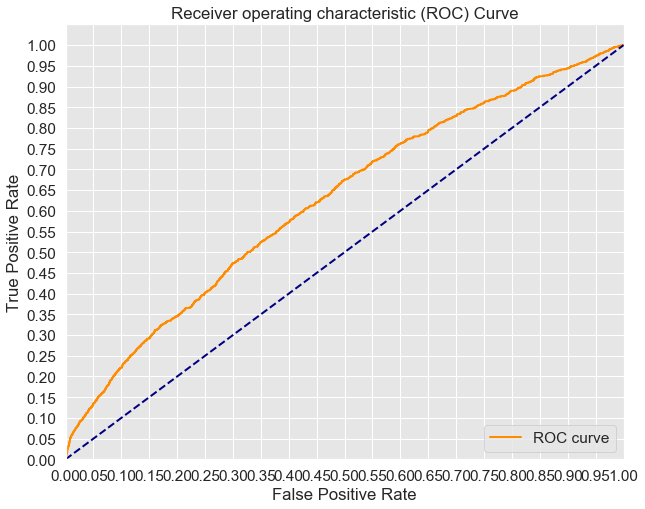

In [73]:
# Try logistic regression
# baseline model
X2 = X_.copy()
y2 = y.copy()

y2 = y2.apply(lambda x: 1 if x > 0 else 0)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Initial Model
logreg1 = LogisticRegression(fit_intercept=False, solver='liblinear', random_state=42)

# Probability scores for test set
y_score = logreg1.fit(X2_train, y2_train).decision_function(X2_test)
# False positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y2_test, y_score)

# Seaborn styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Print AUC
print('AUC: {}'.format(auc(fpr, tpr)))

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Confusion Matrix 



0.25
Logreg score: 0.967


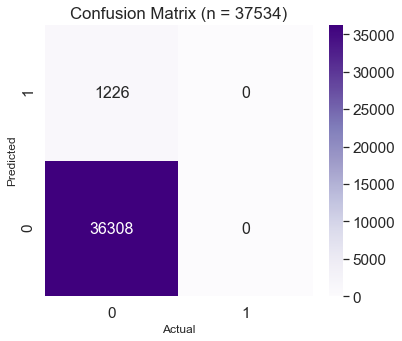

Actual True (crash): 1226, Predicted True: 0
Actual False (no crash): 36308, Predicted False 37534
Percent days with crash: 3.27%

Precision: 0.936
Recall: 0.967
Fscore: 0.951


In [74]:
cutoff = 0.25
print(cutoff)
y_testbool = (logreg1.predict_proba(X2_test)[:,1] >= cutoff).astype(int)
#y_testbool = logreg1.predict(X_test)

score = logreg1.score(X2_test, y2_test)
print('Logreg score: {:.3f}'.format(score))

cm = confusion_matrix(y_testbool, y2_test.astype(bool).astype(int))
#y2_test.unique()
cm

fig, ax = plt.subplots(figsize = (6,5))
sns.set_context('poster')
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm.T, cmap="Purples", annot=True, fmt='g', annot_kws={"size": 16})# font size

plt.title("Confusion Matrix (n = {})".format(len(y2_test)))
plt.xlabel('Actual', fontsize=12)
plt.ylabel('Predicted', fontsize=12)
# Hide major tick labels


# Customize minor tick labels
ax.set_ylim([0,2])
ax.set_xlim([0,2])


#plt.annotate("No Crash: 0\n   Crash: 1", [1.1,0.1], fontsize=10)

plt.show()
# worked with other environment


# scoring model 
prec, recall, fscore, support = precision_recall_fscore_support(y2_test, logreg1.predict(X2_test), average='weighted')

n = len(y2_test)
crash = y2_test.sum()
pred_crash = y_testbool.sum()

print('Actual True (crash): {}, Predicted True: {}\nActual False (no crash): {}, Predicted False {}\nPercent days with crash: {:.2%}'.format(crash, pred_crash, n-crash, n-pred_crash, crash/n))
print('''\nPrecision: {:.3f}
Recall: {:.3f}
Fscore: {:.3f}'''.format(prec, recall, fscore))

## Machine Learning Improvement

Strike the code below if the model performs by giving you 100% guesses for the majority group.

In [75]:
# Machine learning improvement
n = cm[0].sum() + cm[1].sum()  # all test 

p0 = y2_test.sum() / len(y2_test)  # what is the guess rate I would use if I didn't know anything else
p1 = 1 - p0

guessing = p0**2 + p1**2

print("Probability of event: {:.3f}".format(p1))

print('Probability with guessing: {:.3f}'.format(guessing))

ml = (cm[1][1] + cm[0][0]) / n
print('Probability with machine learning: {:.3f}'.format(ml))

increase = (ml - guessing) / guessing
print('\nPercent increase: {:.2%}'.format(increase))

Probability of event: 0.967
Probability with guessing: 0.937
Probability with machine learning: 0.967

Percent increase: 3.26%


## Improve model with SMOTE Oversampling

LogisticRegression(C=0.002, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.002: 0.6371427586817946
-------------------------------------------------------
LogisticRegression(C=0.004, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.004: 0.6396857113896497
-------------------------------------------------------
LogisticRegression(C=0.006, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
     

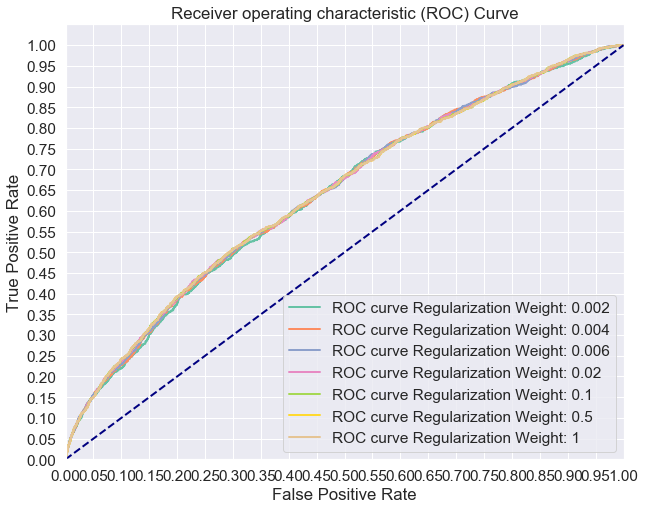

In [77]:
# SMOTE OVERSAMPLING
# Fit SMOTE to same training data
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X2_train, y2_train) 


# Now let's compare a few different regularization performances on the dataset
C_param_range = [0.002, 0.004, 0.006, 0.02, 0.1, 0.5, 1]
names = [0.002, 0.004, 0.006, 0.02, 0.1, 0.5, 1]
colors = sns.color_palette('Set2', n_colors=len(names))

plt.figure(figsize=(10, 8))

for n, c in enumerate(C_param_range):
    # Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='liblinear')
    model_log = logreg.fit(X_train_resampled, y_train_resampled)
    print(model_log) # Preview model params

    # Predict
    y_hat_test = logreg.predict(X2_test)

    y_score = logreg.fit(X_train_resampled, y_train_resampled).decision_function(X2_test)

    fpr, tpr, thresholds = roc_curve(y2_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------')
    
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Regularization Weight: {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Use the best c value for SMOTE

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 1: 0.6413542573318253
-------------------------------------------------------


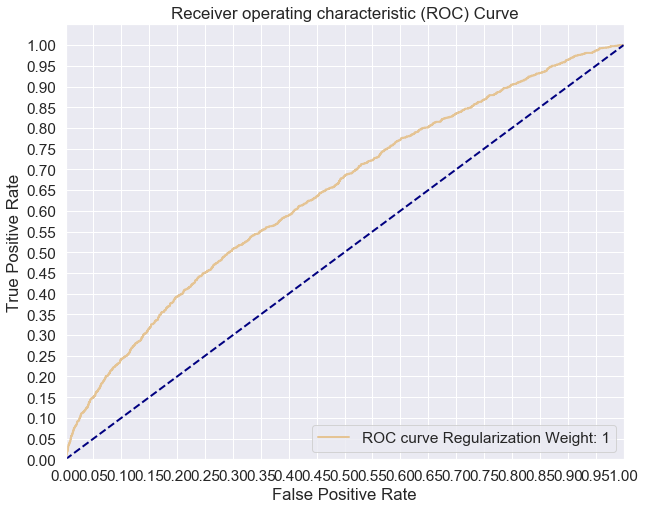

In [82]:
 # Fit a model
logreg_smote = LogisticRegression(fit_intercept=False, C=0.5, solver='liblinear')
model_log = logreg_smote.fit(X_train_resampled, y_train_resampled)
print(model_log) # Preview model params

# Predict
y_hat_test = logreg_smote.predict(X2_test)

y_score = logreg_smote.fit(X_train_resampled, y_train_resampled).decision_function(X2_test)

fpr, tpr, thresholds = roc_curve(y2_test, y_score)

print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
print('-------------------------------------------------------')

plt.figure(figsize=(10, 8))

lw = 2
plt.plot(fpr, tpr, color=colors[n],
         lw=lw, label='ROC curve Regularization Weight: {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Plotting predictions
Plot of the sum probability at each intersection for each day.  I hope that this cumulative approach gives some predictive power to all intersections.

In [93]:
import plotly.express as px
from datetime import datetime

proba = logreg1.predict_proba(X)[:,1]

plotme = all_df.copy()[['datetime', 'n_crash']]
plotme['datetime'] = pd.to_datetime(plotme['datetime'])

plotme['proba'] = proba

plotme.isna().sum()
plotme = plotme.groupby('datetime').agg({'n_crash':'sum', 'proba':'sum'}).reset_index()
plotme['MA_5'] = plotme.n_crash.rolling(5, min_periods=1, center=True).mean()



plotme.head()
plt.figure(figsize=[20, 5])
#plotme_year = plotme[plotme['datetime'] > datetime(2017, 9, 1)]
fig = px.bar(plotme_year, x='datetime', y='n_crash', title='Crashes by Day')
fig.add_scatter(x=plotme_year['datetime'], 
                y=plotme_year['proba'],
                mode='markers',
               name='model prediction',
                marker_color='gray',
               )
fig.add_scatter(x=plotme_year['datetime'],
                y=plotme_year['MA_5'],
                mode='lines',
                hoverinfo='skip',
                name='5 day moving avg.',
                line_color='red',
               )



<Figure size 1440x360 with 0 Axes>

In [86]:
from sklearn import metrics

def cross_val(model, X, y):
    # return a cross val score for my models
    pred = cross_val_score(model, X, y, cv=5)
    return pred.mean()

def print_evaluate(true, predicted):  
    # print out all of my stats for the model
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE: {:.2f}'.format(mae))
    print('MSE: {:.2f}'.format( mse))
    print('RMSE: {:.2f}'.format(rmse))
    print('R2: {:.2f}'.format(r2_square))
    
def evaluate(true, predicted):
    # get multiple stats on my model predictions
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [87]:
plotme.head()
print_evaluate(plotme['n_crash'], plotme['proba'])

MAE: 1.85
MSE: 5.55
RMSE: 2.36
R2: 0.08


## Results
We were NOT able to improve the results using SMOTE.  Both ROC/AUC and score were worse, but wanted the code available if we decide to try the hourly data.

Though we got a reasonable ROC/AUC result from our logistic regression, we found it to have very little predictive ability.  

I had hoped that although the individual events (crashes) are so rare, that using the aggragate probability for every intersection every day would have a predictive effect.  It did not.